# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block_16_expand', 'lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8310 - accuracy: 0.7307

947/947 [==============================] - 3696s 4s/step - loss: 0.8310 - accuracy: 0.7307 - val_loss: 12.5630 - val_accuracy: 0.6644
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.7514

947/947 [==============================] - 3458s 4s/step - loss: 0.7280 - accuracy: 0.7514 - val_loss: 4.8608 - val_accuracy: 0.5660
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7680

947/947 [==============================] - 3482s 4s/step - loss: 0.6682 - accuracy: 0.7680 - val_loss: 2.0112 - val_accuracy: 0.6987
Epoch 4/200
947/947 [==============================] - 3247s 3s/step - loss: 0.6463 - accuracy: 0.7738 - val_loss: 2.4363 - val_accuracy: 0.4466
Epoch 5/200
947/947 [==============================] - 3243s 3s/step - loss: 0.6181 - accuracy: 0.7857 - val_loss: 2.6732 - val_accuracy: 0.4622
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.7884

947/947 [==============================] - 3473s 4s/step - loss: 0.6046 - accuracy: 0.7884 - val_loss: 0.9587 - val_accuracy: 0.6921
Epoch 7/200
947/947 [==============================] - 3256s 3s/step - loss: 0.5854 - accuracy: 0.7929 - val_loss: 1.0112 - val_accuracy: 0.7358
Epoch 8/200
947/947 [==============================] - 3252s 3s/step - loss: 0.5677 - accuracy: 0.8008 - val_loss: 1.3590 - val_accuracy: 0.5731
Epoch 9/200
947/947 [==============================] - 3261s 3s/step - loss: 0.5590 - accuracy: 0.8006 - val_loss: 0.9727 - val_accuracy: 0.7027
Epoch 10/200
947/947 [==============================] - 3251s 3s/step - loss: 0.5483 - accuracy: 0.8056 - val_loss: 1.9143 - val_accuracy: 0.6092
Epoch 11/200
947/947 [==============================] - 3263s 3s/step - loss: 0.5316 - accuracy: 0.8116 - val_loss: 1.0245 - val_accuracy: 0.6903
Epoch 12/200
947/947 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.8178

947/947 [==============================] - 3444s 4s/step - loss: 0.5172 - accuracy: 0.8178 - val_loss: 0.9028 - val_accuracy: 0.7309
Epoch 13/200
947/947 [==============================] - 3255s 3s/step - loss: 0.5089 - accuracy: 0.8185 - val_loss: 1.0944 - val_accuracy: 0.7319
Epoch 14/200
947/947 [==============================] - 3254s 3s/step - loss: 0.5022 - accuracy: 0.8209 - val_loss: 0.9789 - val_accuracy: 0.7397
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.8231

947/947 [==============================] - 3450s 4s/step - loss: 0.4954 - accuracy: 0.8231 - val_loss: 0.8619 - val_accuracy: 0.7582
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8265

947/947 [==============================] - 3458s 4s/step - loss: 0.4825 - accuracy: 0.8265 - val_loss: 0.8614 - val_accuracy: 0.7143
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8296

947/947 [==============================] - 3485s 4s/step - loss: 0.4781 - accuracy: 0.8296 - val_loss: 0.8208 - val_accuracy: 0.7661
Epoch 18/200
947/947 [==============================] - 3275s 3s/step - loss: 0.4700 - accuracy: 0.8319 - val_loss: 0.8612 - val_accuracy: 0.7522
Epoch 19/200
947/947 [==============================] - 3285s 3s/step - loss: 0.4673 - accuracy: 0.8317 - val_loss: 4.7445 - val_accuracy: 0.6104
Epoch 20/200
947/947 [==============================] - 3274s 3s/step - loss: 0.4541 - accuracy: 0.8378 - val_loss: 1.5340 - val_accuracy: 0.7228
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8418

947/947 [==============================] - 3469s 4s/step - loss: 0.4425 - accuracy: 0.8418 - val_loss: 0.7244 - val_accuracy: 0.7630
Epoch 22/200
947/947 [==============================] - 3287s 3s/step - loss: 0.4376 - accuracy: 0.8415 - val_loss: 0.9607 - val_accuracy: 0.7764
Epoch 23/200
947/947 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8463

947/947 [==============================] - 3479s 4s/step - loss: 0.4263 - accuracy: 0.8463 - val_loss: 0.6070 - val_accuracy: 0.7996
Epoch 24/200
947/947 [==============================] - 3278s 3s/step - loss: 0.4217 - accuracy: 0.8466 - val_loss: 0.8592 - val_accuracy: 0.7295
Epoch 25/200
947/947 [==============================] - 3272s 3s/step - loss: 0.4183 - accuracy: 0.8489 - val_loss: 0.8978 - val_accuracy: 0.7555
Epoch 26/200
947/947 [==============================] - 3256s 3s/step - loss: 0.4078 - accuracy: 0.8543 - val_loss: 0.8263 - val_accuracy: 0.7765
Epoch 27/200
947/947 [==============================] - 3292s 3s/step - loss: 0.4059 - accuracy: 0.8530 - val_loss: 0.7194 - val_accuracy: 0.7934
Epoch 28/200
947/947 [==============================] - 3283s 3s/step - loss: 0.3985 - accuracy: 0.8561 - val_loss: 0.7434 - val_accuracy: 0.7698
Epoch 29/200
947/947 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8571

947/947 [==============================] - 3859s 4s/step - loss: 0.3953 - accuracy: 0.8571 - val_loss: 0.5887 - val_accuracy: 0.8064
Epoch 30/200
947/947 [==============================] - 4008s 4s/step - loss: 0.3869 - accuracy: 0.8588 - val_loss: 0.8976 - val_accuracy: 0.7492
Epoch 31/200
947/947 [==============================] - 3783s 4s/step - loss: 0.3837 - accuracy: 0.8608 - val_loss: 0.7763 - val_accuracy: 0.7942
Epoch 32/200
947/947 [==============================] - 3855s 4s/step - loss: 0.3771 - accuracy: 0.8616 - val_loss: 0.6864 - val_accuracy: 0.7914
Epoch 33/200
947/947 [==============================] - 3863s 4s/step - loss: 0.3762 - accuracy: 0.8650 - val_loss: 0.7092 - val_accuracy: 0.7928
Epoch 34/200
947/947 [==============================] - 3654s 4s/step - loss: 0.3680 - accuracy: 0.8675 - val_loss: 0.7231 - val_accuracy: 0.7975
Epoch 35/200
947/947 [==============================] - ETA: 0s - loss: 0.3664 - accuracy: 0.8664

947/947 [==============================] - 3611s 4s/step - loss: 0.3664 - accuracy: 0.8664 - val_loss: 0.5804 - val_accuracy: 0.8069
Epoch 36/200
947/947 [==============================] - 3294s 3s/step - loss: 0.3566 - accuracy: 0.8712 - val_loss: 0.7831 - val_accuracy: 0.7889
Epoch 37/200
947/947 [==============================] - 3633s 4s/step - loss: 0.3530 - accuracy: 0.8729 - val_loss: 0.7261 - val_accuracy: 0.7673
Epoch 38/200
947/947 [==============================] - 4168s 4s/step - loss: 0.3559 - accuracy: 0.8692 - val_loss: 0.8514 - val_accuracy: 0.7720
Epoch 39/200
947/947 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8731

947/947 [==============================] - 4202s 4s/step - loss: 0.3456 - accuracy: 0.8731 - val_loss: 0.5777 - val_accuracy: 0.8192
Epoch 40/200
947/947 [==============================] - 4100s 4s/step - loss: 0.3423 - accuracy: 0.8737 - val_loss: 0.9822 - val_accuracy: 0.7537
Epoch 41/200
947/947 [==============================] - 3957s 4s/step - loss: 0.3362 - accuracy: 0.8769 - val_loss: 0.6709 - val_accuracy: 0.7859
Epoch 42/200
947/947 [==============================] - 3385s 4s/step - loss: 0.3331 - accuracy: 0.8766 - val_loss: 0.6560 - val_accuracy: 0.7973
Epoch 43/200
947/947 [==============================] - 3413s 4s/step - loss: 0.3271 - accuracy: 0.8792 - val_loss: 0.6371 - val_accuracy: 0.7917
Epoch 44/200
947/947 [==============================] - 3887s 4s/step - loss: 0.3248 - accuracy: 0.8822 - val_loss: 1.1883 - val_accuracy: 0.7443
Epoch 45/200
947/947 [==============================] - 3989s 4s/step - loss: 0.3185 - accuracy: 0.8826 - val_loss: 0.8312 - val_accuracy

947/947 [==============================] - 4077s 4s/step - loss: 0.2907 - accuracy: 0.8931 - val_loss: 0.5647 - val_accuracy: 0.8259
Epoch 52/200
947/947 [==============================] - 4297s 5s/step - loss: 0.2912 - accuracy: 0.8934 - val_loss: 0.5851 - val_accuracy: 0.8048
Epoch 53/200
947/947 [==============================] - 4106s 4s/step - loss: 0.2904 - accuracy: 0.8946 - val_loss: 0.6704 - val_accuracy: 0.8033
Epoch 54/200
947/947 [==============================] - 4297s 5s/step - loss: 0.2864 - accuracy: 0.8963 - val_loss: 0.8065 - val_accuracy: 0.7735
Epoch 55/200
947/947 [==============================] - 7846s 8s/step - loss: 0.2746 - accuracy: 0.9004 - val_loss: 1.0950 - val_accuracy: 0.7110
Epoch 56/200
947/947 [==============================] - 8593s 9s/step - loss: 0.2857 - accuracy: 0.8951 - val_loss: 0.6674 - val_accuracy: 0.8070
Epoch 57/200
947/947 [==============================] - 7372s 8s/step - loss: 0.2773 - accuracy: 0.8987 - val_loss: 0.6099 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 522s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9724051859483858,
 'basal cell carcinoma': 0.9859868356862481,
 'dermatofibroma': 0.9533629920072388,
 'melanoma': 0.937866140940986,
 'nevus': 0.965110474604462,
 'pigmented benign keratosis': 0.9869996270911827,
 'seborrheic keratosis': 0.9633162743805228,
 'solar lentigo': 0.9611523421913654,
 'squamous cell carcinoma': 0.968296547901596,
 'vascular lesion': 0.9997148271484555}

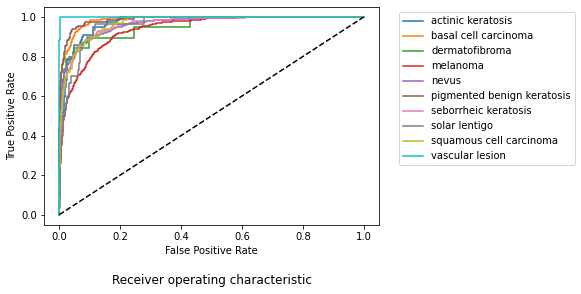

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

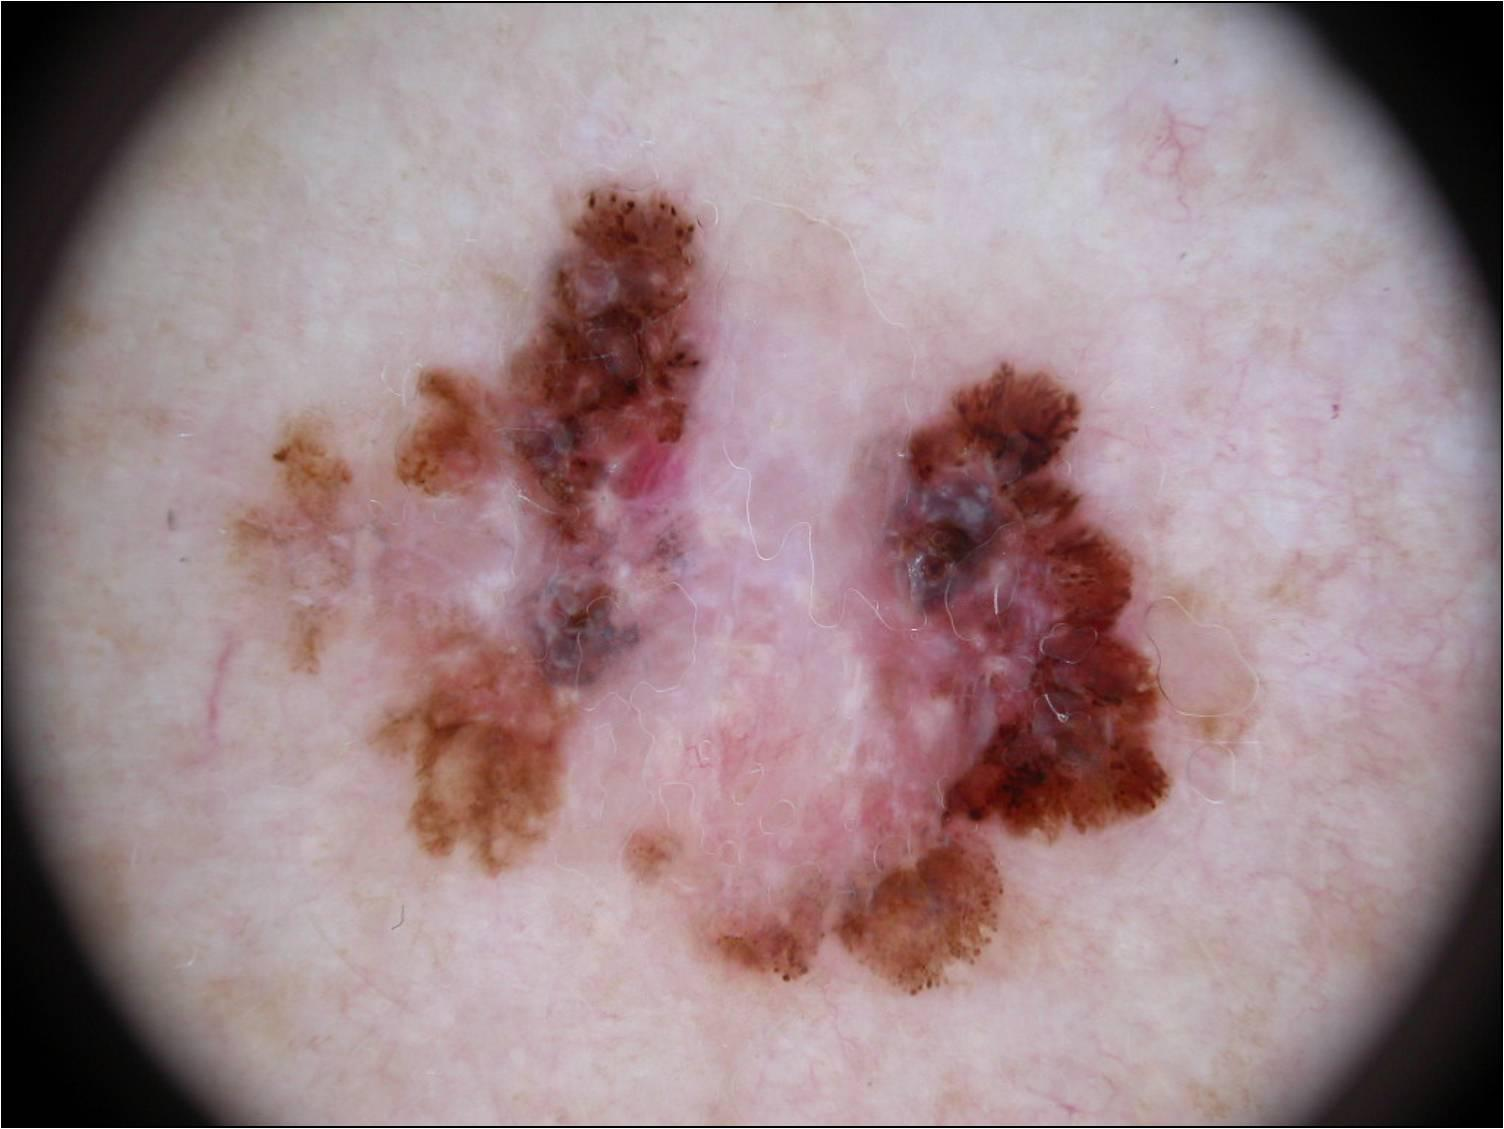

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

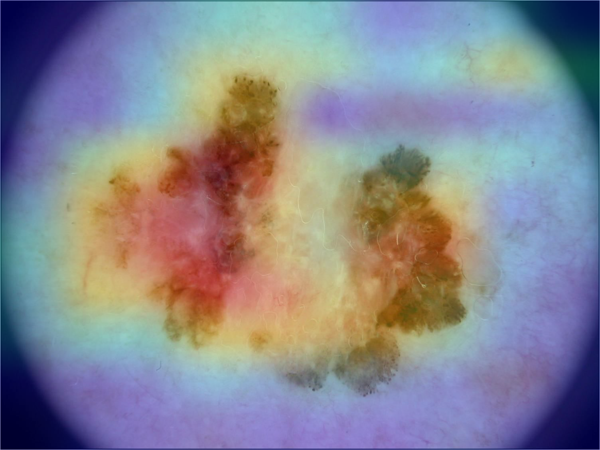

In [23]:
display_gradcam(melanoma_im_path, heatmap)